In [ ]:
!pip install causalml
!pip install pyro-ppl

# CEVAE ÏΩîÎìú (predict ÏàòÏ†ï)

In [1]:

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(
        self,
        outcome_dist="studentt",
        latent_dim=20,
        hidden_dim=200,
        num_epochs=50,
        num_layers=3,
        batch_size=100,
        learning_rate=1e-3,
        learning_rate_decay=0.1,
        num_samples=1000,
        weight_decay=1e-4,
    ):
        """
        Initializes CEVAE.

            Args:
                outcome_dist (str): Outcome distribution as one of: "bernoulli" , "exponential", "laplace", "normal",
                                    and "studentt"
                latent_dim (int) : Dimension of the latent variable
                hidden_dim (int) : Dimension of hidden layers of fully connected networks
                num_epochs (int): Number of training epochs
                num_layers (int): Number of hidden layers in fully connected networks
                batch_size (int): Batch size
                learning_rate (int): Learning rate
                learning_rate_decay (float/int): Learning rate decay over all epochs; the per-step decay rate will
                                                 depend on batch size and number of epochs such that the initial
                                                 learning rate will be learning_rate and the
                                                 final learning rate will be learning_rate * learning_rate_decay
                num_samples (int) : Number of samples to calculate ITE
                weight_decay (float) : Weight decay
        """
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        """
        Fits CEVAE.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(
            outcome_dist=self.outcome_dist,
            feature_dim=X.shape[-1],
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
        )

        self.cevae.fit(
            x=torch.tensor(X, dtype=torch.float),
            t=torch.tensor(treatment, dtype=torch.float),
            y=torch.tensor(y, dtype=torch.float),
            num_epochs=self.num_epochs,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            learning_rate_decay=self.learning_rate_decay,
            weight_decay=self.weight_decay,
        )

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return (
            self.cevae.ite(
                torch.tensor(X, dtype=torch.float),
                num_samples=self.num_samples,
                batch_size=self.batch_size,
            )
            # .cpu()
            .numpy()
        )

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

ModuleNotFoundError: No module named 'pyro'

# CEVAE (Causal Effect Variational Autoencoder)
ÏÑ§Î™Ö ÏûêÎ£å [Link](https://velog.io/@qtly_u/CEVAE-Causal-Effect-Inference-with-Deep-Latent-Variable-Models)


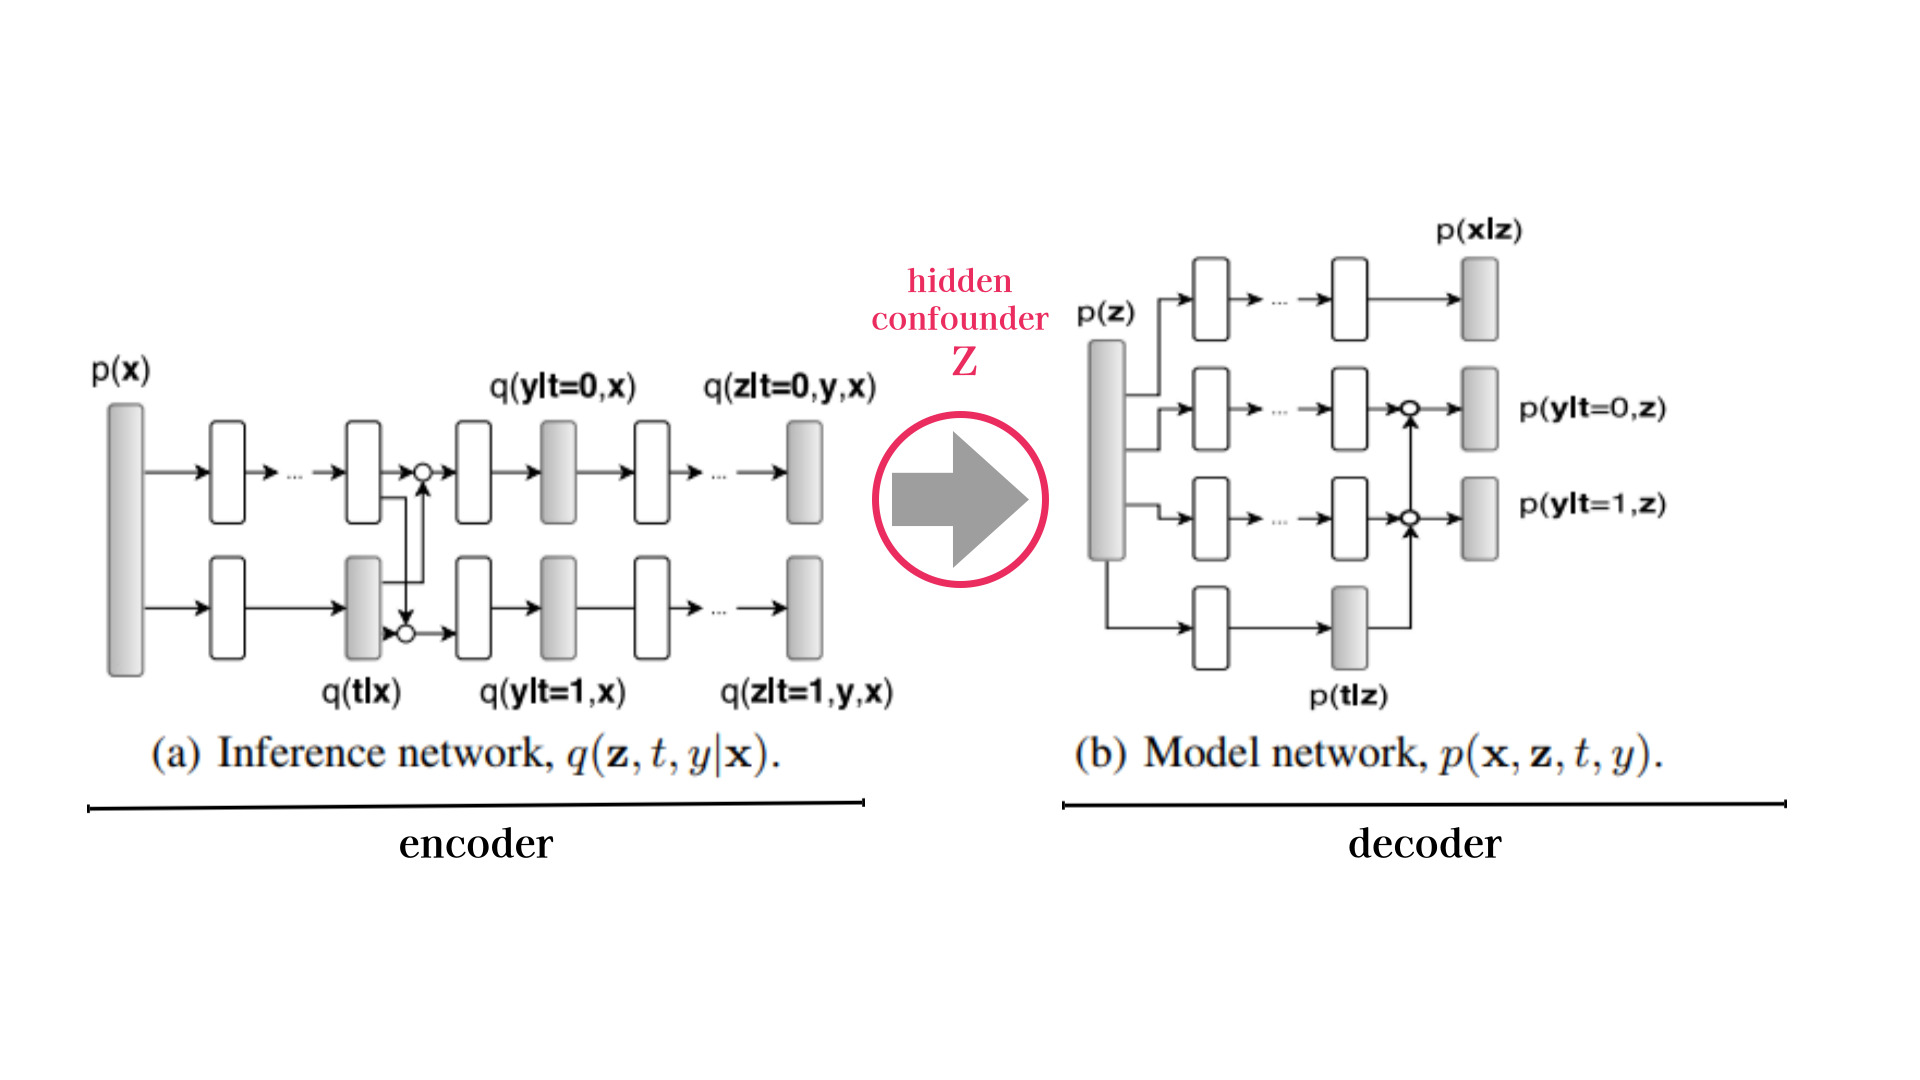

## Î™©Ï†Å:
CEVAEÎäî Í¥ÄÏ∏° Îç∞Ïù¥ÌÑ∞ÎßåÏúºÎ°ú Í∞úÎ≥Ñ Ï≤òÏπòÌö®Í≥º(ITE: Individual Treatment Effect)Î•º Ï∂îÏ†ïÌïòÎäî Î™®Îç∏

## VAE Íµ¨Ï°∞Î•º ÏÇ¨Ïö©ÌïòÎäî Ïù¥Ïú†
Í¥ÄÏ∏°Îêú Îç∞Ïù¥ÌÑ∞ÏóêÎäî Î≥¥ÌÜµ **ÌòºÎûÄÎ≥ÄÏàò(confounder)**Í∞Ä Ïà®Ïñ¥ ÏûàÍ≥†, Ïù¥ ÌòºÎûÄÎ≥ÄÏàòÎ•º ÏßÅÏ†ë Í¥ÄÏ∏°Ìï† Ïàò ÏóÜÎäî Í≤ΩÏö∞Í∞Ä ÎßéÍ∏∞ ÎïåÎ¨∏Ïóê Î™®Îç∏Ïù¥ Ïù¥Î•º **Ïû†Ïû¨Î≥ÄÏàò(latent variable)**Î°ú Í∞ÑÏ£ºÌïòÍ≥† Ï∂îÏ†ï `(Í≥ºÏó∞ xÎ°ú ÌëúÌòÑÌï† Ïàò ÏûàÏùÑÏßÄÎäî Î™®Î•¥Í≤†Ïùå)`

Ïó¨Í∏∞ÏÑú VAEÍ∞Ä Îì±Ïû•ÌïòÎäî Ïù¥Ïú†:
VAEÎäî Í¥ÄÏ∏°ÎêòÏßÄ ÏïäÏùÄ Ïû†Ïû¨ Î≥ÄÏàòÎ•º ÌïôÏäµÌïòÍ≥† Ïû¨Íµ¨ÏÑ±ÌïòÎäî Îç∞ Í∞ïÎ†•Ìïú ÎèÑÍµ¨Ïù¥Í∏∞ ÎïåÎ¨∏.

CEVAEÎäî **Í¥ÄÏ∏°Îêú Î≥ÄÏàò(X)**Î°úÎ∂ÄÌÑ∞ **Ïû†Ïû¨Îêú ÏõêÏù∏(Z)**Î•º Ï∂îÏ†ïÌïòÍ≥†,
Ïù¥ ZÎ•º Ïù¥Ïö©Ìï¥ **Ï≤òÏπò(T)**ÏôÄ **Í≤∞Í≥º(Y)**Î•º ÏÉùÏÑ±ÌïòÎ†§Îäî ÌôïÎ•† Î™®Îç∏ÏùÑ ÏÉùÏÑ±

---
---

- X: Í¥ÄÏ∏°Îêú ÌäπÏßï Ï†ïÎ≥¥ (Ïòà: ÎÇòÏù¥, ÏÑ±Î≥Ñ Îì±)
- T: Ï≤òÏπò Ïó¨Î∂Ä (Ïòà: Ïã†ÏïΩ Î≥µÏö© Ïó¨Î∂Ä)
- Y: Í≤∞Í≥º (Ïòà: ÌöåÎ≥µ Ïó¨Î∂Ä Îì±)
- Z:  Í¥ÄÏ∏°ÎêòÏßÄ ÏïäÏùÄ ÏßÑÏßú ÏõêÏù∏(Ïù∏Í≥ºÏ†Å Íµ¨Ï°∞Î•º ÏÑ§Î™ÖÌïòÎäî Ïû†Ïû¨ ÏöîÏù∏)


## Ï†ÑÏ≤¥ Î™®Îç∏ Íµ¨Ï°∞

Ïù∏ÏΩîÎçî (Inference model):
- Í¥ÄÏ∏°Îêú ùëã,ùëá,ùëå Î°úÎ∂ÄÌÑ∞ Ïû†Ïû¨ Î≥ÄÏàò ùëçÏùò Î∂ÑÌè¨Î•º Ï∂îÏ†ïÌï®
- Ï¶â, ùëû(ùëß‚à£ùë•,ùë°,ùë¶)

ÎîîÏΩîÎçî (Generative model):
- ùëçÎ°úÎ∂ÄÌÑ∞ ùëã,ùëá,ùëå Î•º ÏÉùÏÑ±ÌïòÎäî Í≥ºÏ†ïÏùÑ ÌïôÏäµÌï®
- Ï¶â,ùëù(ùë•‚à£ùëß),ùëù(ùë°‚à£ùëß),ùëù(ùë¶‚à£ùëß,ùë°)

Ïù¥Í±∏ ÌÜµÌï¥ Î™®Îç∏ÏùÄ "ZÎùºÎäî ÏõêÏù∏Ïù¥ ÏûàÏóàÎã§Î©¥, Ïñ¥Îñ§ XÍ∞Ä ÎÇòÏò§Í≥†, TÎäî Ïñ¥ÎñªÍ≤å ÏÑ†ÌÉùÎêòÍ≥†, YÎäî Ïñ¥ÎñªÍ≤å Í≤∞Í≥ºÍ∞Ä ÎêòÎäîÍ∞Ä?"Î•º ÌïôÏäµ.

## Ï∂îÎ°†ÏùÄ Ïñ¥Îñ§ Í≥ºÏ†ïÏù∏ÏßÄ?
ÌïôÏäµÏù¥ ÎÅùÎÇòÎ©¥, ÏÉàÎ°úÏö¥ ÏÇ¨ÎûåÏóê ÎåÄÌï¥:

Í∑∏ ÏÇ¨ÎûåÏùò ùëãÎ•º Í∞ÄÏßÄÍ≥†, Ïû†Ïû¨ Î≥ÄÏàò ùëçÎ•º Ï∂îÏ†ïÌïòÍ≥†,

Í∞ÅÍ∞Å ùëá=1, ùëá=0Ïùº ÎïåÏùò Í≤∞Í≥º ùëå Î•º ÏòàÏ∏°Ìï¥ÏÑú Îëê Í≤∞Í≥ºÏùò Ï∞®Ïù¥Î•º ITEÎ°ú Ï∂îÏ†ï.

Ï¶â:
ùêºùëáùê∏(ùë•)=ùë¶(ùë°=1,ùë•)‚àíùë¶(ùë°=0,ùë•)


## Í≤∞Íµ≠.
"Ïû†Ïû¨Îêú ÏõêÏù∏(Z)ÏùÑ Î™®Îç∏Ïù¥ Ïú†Ï∂îÌï¥ÏÑú X, T, YÎ•º ÏÑ§Î™ÖÌïúÎã§"

"Î™®Îç∏Ïù¥ ÌïôÏäµÌïú ZÎ•º Î∞îÌÉïÏúºÎ°ú T=1Í≥º T=0Ïùò Í≤∞Í≥º Ï∞®Ïù¥Î•º ÏòàÏ∏°ÌïúÎã§"

In [10]:
# from causalml.inference.torch import CEVAE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.torch import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

from lightgbm import LGBMRegressor

# IHDP semi-synthetic dataset

Hill introduced a semi-synthetic dataset constructed from the Infant Health and Development Program.

"Ìûê"ÏùÄ ÏòÅÏïÑ Í±¥Í∞ï Î∞è Î∞úÎã¨ ÌîÑÎ°úÍ∑∏Îû®(IHDP)ÏóêÏÑú Íµ¨Ï∂ïÎêú Î∞òÌï©ÏÑ± Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Î•º ÏÜåÍ∞úÌñàÏäµÎãàÎã§. Ïù¥ Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Îäî Ï†ÑÎ¨∏Í∞ÄÏùò Í∞ÄÏ†ï Î∞©Î¨∏Ïù¥ Ìñ•ÌõÑ Ïù∏ÏßÄ Ï†êÏàòÏóê ÎØ∏ÏπòÎäî ÏòÅÌñ•ÏùÑ Ï°∞ÏÇ¨ÌïòÎäî Î¨¥ÏûëÏúÑ Ïã§ÌóòÏóê Í∏∞Î∞òÌï©ÎãàÎã§. IHDP ÏãúÎÆ¨Î†àÏù¥ÏÖòÏùÄ Ïã†Í≤ΩÎßù ÏπòÎ£å Ìö®Í≥º Ï∂îÏ†ï Î∞©Î≤ïÏùò ÏÇ¨Ïã§ÏÉÅ ÌëúÏ§Ä Î≤§ÏπòÎßàÌÅ¨Î°ú Í∞ÑÏ£ºÎê©ÎãàÎã§.

Ïù∏ÏßÄ Îä•Î†• Ï†êÏàòÏóê ÎØ∏ÏπòÎäî ÏòÅÌñ•ÏùÑ ÌôïÏù∏ÌïòÍ∏∞ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ ÏÖã.

In [4]:
# load all ihdp data
df_raw = pd.DataFrame()
for i in range(1, 10):
    url = f"""https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_{i}.csv"""
    data= pd.read_csv(url, header = None)
    df_raw = pd.concat([data, df_raw])
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df_raw.columns = cols
print(df_raw.shape)

# Deep Learning ÌïôÏäµÏùÑ ÏúÑÌï¥ 100Î∞∞ Î≥µÏ†ú
replications = 100
df = pd.concat([df_raw]*replications, ignore_index=True).reset_index(drop=True)
print(df.shape)

(6723, 30)
(672300, 30)


In [5]:
# Ïù¥ÏßÑÌòï Î≥ÄÏàò
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# Ïó∞ÏÜçÌòï Î≥ÄÏàò
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features
perm = binfeats + contfeats
df = df.reset_index(drop=True)
df.head()

# Î∞ò ÏÇ¨Ïã§ Í≤∞Í≥ºÎ•º ÌôïÏù∏Ìï† Ïàò ÏûàÎäî Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞ÏÖã ÏûÖÎãàÎã§.

treatment  y_factual  y_cfactual        mu0        mu1         0         1  \
0          1  49.647921   34.950762  37.173291  50.383798 -0.528603 -0.343455   
1          0  16.073412   49.435313  16.087249  49.546234 -1.736945 -1.802002   
2          0  19.643007   48.598210  18.044855  49.661068 -0.807451 -0.202946   
3          0  26.368322   49.715204  24.605964  49.971196  0.390083  0.596582   
4          0  20.258893   51.147418  20.612816  49.794120 -1.045229 -0.602710   

          2         3         4  ...  15  16  17  18  19  20  21  22  23  24  
0  1.128554  0.161703 -0.316603  ...   1   1   1   1   0   0   0   0   0   0  
1  0.383828  2.244320 -0.629189  ...   1   1   1   1   0   0   0   0   0   0  
2 -0.360898 -0.879606  0.808706  ...   1   0   1   1   0   0   0   0   0   0  
3 -1.850350 -0.879606 -0.004017  ...   1   0   1   1   0   0   0   0   0   0  
4  0.011465  0.161703  0.683672  ...   1   1   1   1   0   0   0   0   0   0  

[5 rows x 30 columns]

In [6]:
# Îî•Îü¨Îãù ÌïôÏäµÏö©
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]



# ÏòàÏ∏°Ïö© Îç∞Ïù¥ÌÑ∞ ÏÖã (Îî•Îü¨Îãù ÌïôÏäµ ÏòàÏ∏°ÏÖãÏù¥ ÎÑàÎ¨¥ ÌÅ¨Îã§)
X = df_raw[perm].values
treatment = df_raw['treatment'].values
y = df_raw['y_factual'].values
y_cf = df_raw['y_cfactual'].values
tau = df_raw.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train_raw, treatment_train_raw, y_train_raw, y_cf_train_raw, tau_train_raw = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val= X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

In [7]:
# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000 * 2
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

In [8]:
cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

In [9]:
# fit (2Î∂Ñ))
losses = cevae.fit(
    X=torch.tensor(X_train, dtype=torch.float),
    treatment=torch.tensor(treatment_train, dtype=torch.float),
    y=torch.tensor(y_train, dtype=torch.float)
)


INFO:pyro.contrib.cevae:Training with 269 minibatches per epoch
DEBUG:pyro.contrib.cevae:step     0 loss = 752.302
DEBUG:pyro.contrib.cevae:step   100 loss = 36.1147
DEBUG:pyro.contrib.cevae:step   200 loss = 23.3251
DEBUG:pyro.contrib.cevae:step   300 loss = 18.5594
DEBUG:pyro.contrib.cevae:step   400 loss = 14.9276
DEBUG:pyro.contrib.cevae:step   500 loss = 13.4495
DEBUG:pyro.contrib.cevae:step   600 loss = 12.0499
DEBUG:pyro.contrib.cevae:step   700 loss = 10.1288
DEBUG:pyro.contrib.cevae:step   800 loss = 9.8599
DEBUG:pyro.contrib.cevae:step   900 loss = 8.9111
DEBUG:pyro.contrib.cevae:step  1000 loss = 9.0098
DEBUG:pyro.contrib.cevae:step  1100 loss = 8.08949
DEBUG:pyro.contrib.cevae:step  1200 loss = 8.33889
DEBUG:pyro.contrib.cevae:step  1300 loss = 8.70999


In [11]:
# predict (2Î∂Ñ)
ite_train = cevae.predict(X_train_raw) #.cpu()
ite_val = cevae.predict(X_val)

INFO:pyro.contrib.cevae:Evaluating 3 minibatches
DEBUG:pyro.contrib.cevae:batch ate = 3.19685
DEBUG:pyro.contrib.cevae:batch ate = 3.1681
DEBUG:pyro.contrib.cevae:batch ate = 3.28275
INFO:pyro.contrib.cevae:Evaluating 1 minibatches
DEBUG:pyro.contrib.cevae:batch ate = 3.20532


In [12]:
ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

3.2081695 3.2053177


# Î©îÌÉÄ Îü¨ÎÑàÏôÄ ÎπÑÍµê

In [13]:
# fit propensity model
p_model = ElasticNetPropensityModel()
p_train = p_model.fit_predict(X_train_raw, treatment_train_raw)
p_val = p_model.fit_predict(X_val, treatment_val)

In [14]:
s_learner = BaseSRegressor(LGBMRegressor(verbose=-1))
s_ate = s_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw)[0]
s_ite_train = s_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw)
s_ite_val = s_learner.predict(X_val)

t_learner = BaseTRegressor(LGBMRegressor(verbose=-1))
t_ate = t_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw)[0][0]
t_ite_train = t_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw)
t_ite_val = t_learner.predict(X_val, treatment_val, y_val)

x_learner = BaseXRegressor(LGBMRegressor(verbose=-1))
x_ate = x_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw, p_train)[0][0]
x_ite_train = x_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw, p_train)
x_ite_val = x_learner.predict(X_val, treatment_val, y_val, p_val)

r_learner = BaseRRegressor(LGBMRegressor(verbose=-1))
r_ate = r_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw, p_train)[0][0]
r_ite_train = r_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw, p_train)
r_ite_val = r_learner.predict(X_val)

# Model Results Comparsion
## Training

In [15]:
df_preds_train = pd.DataFrame([s_ite_train.ravel(),
                               t_ite_train.ravel(),
                               x_ite_train.ravel(),
                               r_ite_train.ravel(),
                               ite_train.ravel(),
                               tau_train_raw.ravel(),
                               treatment_train_raw.ravel(),
                               y_train_raw.ravel()],
                               index=['S','T','X','R','CEVAE','tau','w','y']).T

df_cumgain_train = get_cumgain(df_preds_train)

In [16]:
df_result_train = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, ate_train, tau_train_raw.mean()],
                               index=['S','T','X','R','CEVAE','actual'], columns=['ATE'])
df_result_train['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite_train, t_ite_train, x_ite_train, r_ite_train, ite_train],
                                                                  [tau_train_raw.values.reshape(-1,1)]*5 )
                          ] + [None]
df_result_train['AUUC'] = auuc_score(df_preds_train)

In [17]:
df_result_train

ATE       MAE      AUUC
S       4.661763  4.533111  0.664618
T       4.639223  5.068461  0.641973
X       4.711447  4.575492  0.646738
R       0.946511  6.142228  0.552620
CEVAE   3.208169  4.975471  0.568401
actual  4.809767       NaN       NaN

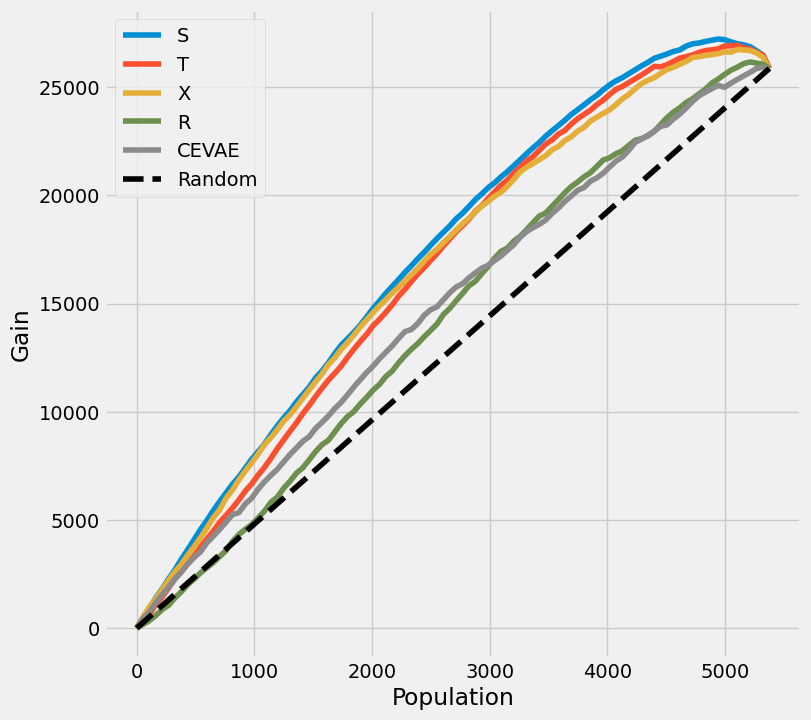

In [18]:
plot_gain(df_preds_train)

In [19]:
# ÏòàÏ∏°Í∞í Ï§ë, Ï∞®Ïù¥Í∞Ä Í∞ÄÏû• ÌÅ∞ Ìï≠Î™© ÌôïÏù∏ (3,695 Ìñâ)
diff = s_ite_train.ravel() - ite_train.ravel()
diff_max_idx = diff.argmax() # 3,695 Ìñâ
diff_max_idx

np.int64(3695)

In [20]:
X_train_raw#, treatment_train_raw, y_train_raw, y_cf_train_raw, tau_train_raw
q1 = pd.DataFrame(X_train_raw)
q2 = pd.DataFrame(treatment_train_raw, columns=['treatment'])
q3 = pd.DataFrame(y_train_raw.ravel(), columns=['y_factual'])
q4 = pd.DataFrame(tau_train_raw.ravel(), columns=['tau_train_raw'])

df_train_raw = pd.concat([q1, q2, q3, q4], axis = 1)
df_train_raw['s_leaner'] = s_ite_train.ravel()
df_train_raw['cevae'] = ite_train.ravel()

In [21]:
df_train_raw.iloc[diff_max_idx]
# CEVAEÎäî ÏùåÏàòÎ°ú Ï∂îÏ†ï

0                1.000000
1                0.000000
2                1.000000
3                0.000000
4                0.000000
5                1.000000
6                0.000000
7                2.000000
8                0.000000
9                1.000000
10               0.000000
11               1.000000
12               0.000000
13               0.000000
14               0.000000
15               0.000000
16               0.000000
17               0.000000
18               1.000000
19               1.440627
20               0.996346
21              -1.477987
22              -0.879606
23              -1.066810
24               1.129600
treatment        0.000000
y_factual        0.930787
tau_train_raw    6.082058
s_leaner         7.257267
cevae           -9.935463
Name: 3695, dtype: float64